Modelo BaseLine de cletas: Regresión Poisson.    v.7.     AH


In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
df = pd.read_csv('/Users/alejandroherreralegaspi/Documents/Proyectos IA Maestria/Python/Bases de datos/bike_sharing_cleaned.csv')

formula = 'cnt ~ temp + hum + windspeed + holiday + workingday + C(season) + C(weathersit)'

try:
    poisson_model = smf.poisson(formula=formula, data=dfm).fit()
except np.linalg.LinAlgError:
    # Si sigue fallando, quitar otra variable categórica
    formula = 'cnt ~ temp + hum + windspeed + holiday + workingday + C(season)'
    poisson_model = smf.poisson(formula=formula, data=dfm).fit()

print(poisson_model.summary())


effects_pct = 100 * (np.exp(poisson_model.params) - 1)
print("\nEfectos porcentuales estimados (%):")
print(effects_pct.round(2))

In [4]:
drop_cols = [c for c in ['atemp','instant','dteday','casual','registered'] if c in df.columns]
df = df.drop(columns=drop_cols)


for c in ['season','mnth','weekday','weathersit']:
    if c in df: df[c] = df[c].astype('category')

for c in ['yr','holiday','workingday','temp','hum','windspeed','cnt','hr']:
    if c in df: df[c] = pd.to_numeric(df[c], errors='coerce')

for c in ['yr','holiday','workingday']:
    if c in df: df[c] = df[c].clip(lower=0, upper=1)


df = df.dropna(subset=[c for c in ['cnt','temp','hum','windspeed','yr','holiday','workingday'] if c in df.columns])


formulas = [
    'cnt ~ temp + hum + windspeed',
    'cnt ~ temp + hum + windspeed + yr',
    'cnt ~ temp + hum + windspeed + yr + holiday',
    'cnt ~ temp + hum + windspeed + yr + holiday + workingday',
    'cnt ~ temp + hum + windspeed + yr + holiday + workingday + C(season)',
    'cnt ~ temp + hum + windspeed + yr + holiday + workingday + C(season) + C(weathersit)',

]

poisson_model = None
formula_ok = None
for f in formulas:
    try:
        poisson_model = smf.poisson(formula=f, data=df).fit(disp=False)
        formula_ok = f
        print(f' OK: {f}')
    except Exception as e:
        print(f' Falla: {f} -> {type(e).__name__}: {e}')
        break

if poisson_model is None:
    
    print('\n Pasando a Poisson regularizado (ridge) para evitar singularidad…')
    f_full = 'cnt ~ temp + hum + windspeed + yr + holiday + workingday + C(season) + C(weathersit)'
    poisson_model = smf.poisson(formula=f_full, data=df).fit_regularized(alpha=1e-4, L1_wt=0.0)
    formula_ok = f_full + '  [regularized]'

print('\n Fórmula usada:')
print(formula_ok)
print('\n', poisson_model.summary())

# Efectos porcentuales
coefs = poisson_model.params
effects_pct = 100 * (np.exp(coefs) - 1)
print('\n Efectos porcentuales estimados (%):')
print(effects_pct.round(2))

 OK: cnt ~ temp + hum + windspeed
 OK: cnt ~ temp + hum + windspeed + yr
 OK: cnt ~ temp + hum + windspeed + yr + holiday
 OK: cnt ~ temp + hum + windspeed + yr + holiday + workingday
 OK: cnt ~ temp + hum + windspeed + yr + holiday + workingday + C(season)
 Falla: cnt ~ temp + hum + windspeed + yr + holiday + workingday + C(season) + C(weathersit) -> LinAlgError: Singular matrix

 Fórmula usada:
cnt ~ temp + hum + windspeed + yr + holiday + workingday + C(season)

                           Poisson Regression Results                          
Dep. Variable:                    cnt   No. Observations:                17275
Model:                        Poisson   Df Residuals:                    17263
Method:                           MLE   Df Model:                           11
Date:                Sun, 12 Oct 2025   Pseudo R-squ.:                  0.3068
Time:                        08:51:59   Log-Likelihood:            -1.0509e+06
converged:                       True   LL-Null:       

In [46]:
effects_pct = 100 * (np.exp(poisson_model.params) - 1)
print("\nEfectos porcentuales estimados (%):")
print(effects_pct.round(2))


Efectos porcentuales estimados (%):
Intercept             8590.70
C(season)[T.2.0]        11.89
C(season)[T.3.0]        -7.48
C(season)[T.4.0]        53.04
C(season)[T.40.0]      -60.32
C(season)[T.781.0]     -96.82
temp                   768.60
hum                    -72.15
windspeed               31.80
yr                      51.02
holiday                -12.04
workingday               1.80
dtype: float64


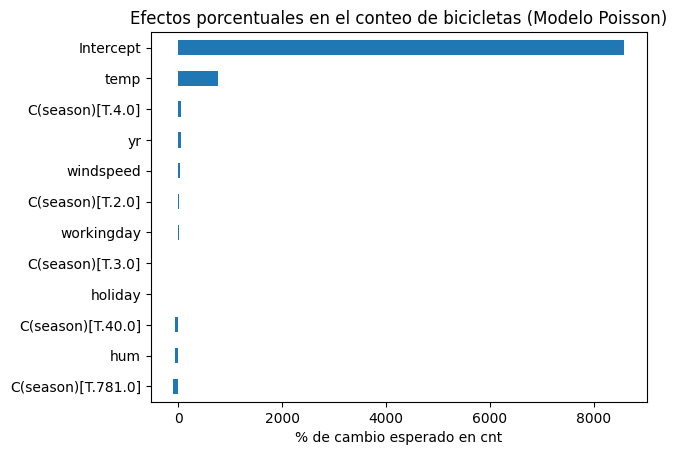

In [ ]:
effects_pct.sort_values().plot(kind='barh')
plt.title('Efectos porcentuales en el conteo de bicicletas (Modelo Poisson)')
plt.xlabel('% de cambio esperado en cnt')
plt.show()


 Evaluación del Modelo Poisson:
              Métrica    Valor
0                 MAE  113.830
1                RMSE  152.972
2           Pseudo R²    0.307
3        Promedio cnt  192.291
4  Error relativo (%)   59.197


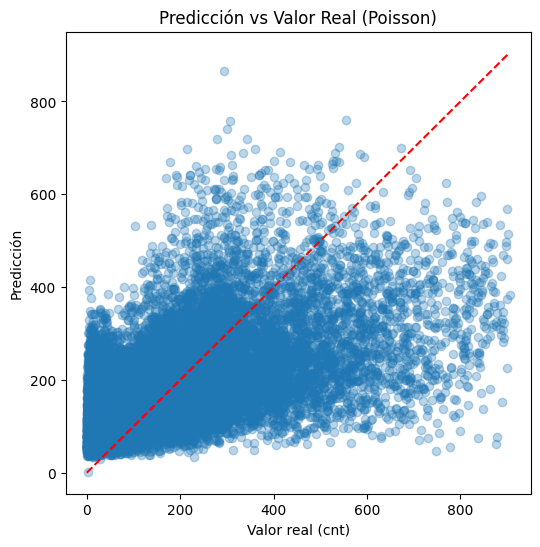

In [ ]:
# --- Evaluación del modelo Poisson ---

y_true = df['cnt']
y_pred = poisson_model.predict(df)

mask = (~y_true.isna()) & (~pd.Series(y_pred).isna())
y_true_clean = y_true[mask]
y_pred_clean = pd.Series(y_pred)[mask]


mae = mean_absolute_error(y_true_clean, y_pred_clean)
rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))


llf = poisson_model.llf         
llnull = poisson_model.llnull    
pseudo_r2 = 1 - (llf / llnull)


mean_cnt = y_true.mean()
error_relativo = (mae / mean_cnt) * 100


resultados = pd.DataFrame({
    'Métrica': ['MAE', 'RMSE', 'Pseudo R²', 'Promedio cnt', 'Error relativo (%)'],
    'Valor': [mae, rmse, pseudo_r2, mean_cnt, error_relativo]
})

print("\n Evaluación del Modelo Poisson:")
print(resultados.round(3))


import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.plot([0, max(y_true)], [0, max(y_true)], color='red', linestyle='--')
plt.title("Predicción vs Valor Real (Poisson)")
plt.xlabel("Valor real (cnt)")
plt.ylabel("Predicción")
plt.show()

In [61]:
y_true = df['cnt']
y_pred = poisson_model.predict(df)


mask = (~y_true.isna()) & (~pd.Series(y_pred).isna())
y_true_clean = y_true[mask]
y_pred_clean = pd.Series(y_pred)[mask]


mae = mean_absolute_error(y_true_clean, y_pred_clean)
rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
pseudo_r2 = 1 - poisson_model.llf / poisson_model.llnull


mean_cnt = y_true.mean()
error_rel = (mae / mean_cnt) * 100  # %

max_cnt = y_true.max()
mae_norm = mae / max_cnt
rmse_norm = rmse / max_cnt

resultados = pd.DataFrame({
    "Métrica": ["MAE", "RMSE", "Pseudo R²", "Promedio cnt", "Error relativo (%)", 
                "MAE Normalizado", "RMSE Normalizado"],
    "Valor": [mae, rmse, pseudo_r2, mean_cnt, error_rel, mae_norm, rmse_norm]
})

print(" Evaluación del Modelo Poisson:\n")
display(resultados.round(4))


print("\n Interpretación:")
print(f"- En promedio, el modelo se desvía {mae:.1f} bicicletas por observación.")
print(f"- Esto equivale a un error relativo del {error_rel:.1f}%.")
print(f"- En escala normalizada (0–1), el MAE ≈ {mae_norm:.3f} y RMSE ≈ {rmse_norm:.3f}.")
print(f"- El Pseudo R² = {pseudo_r2:.3f} indica que el modelo explica aproximadamente el {pseudo_r2*100:.1f}% de la variabilidad.")

 Evaluación del Modelo Poisson:



,Métrica,Valor
0,MAE,113.8301
1,RMSE,152.9717
2,Pseudo R²,0.3068
3,Promedio cnt,192.2908
4,Error relativo (%),59.1969
5,MAE Normalizado,0.1258
6,RMSE Normalizado,0.1690



 Interpretación:
- En promedio, el modelo se desvía 113.8 bicicletas por observación.
- Esto equivale a un error relativo del 59.2%.
- En escala normalizada (0–1), el MAE ≈ 0.126 y RMSE ≈ 0.169.
- El Pseudo R² = 0.307 indica que el modelo explica aproximadamente el 30.7% de la variabilidad.
